                                        **EVALUATION TEST : DEEPLENSE**
                             


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from typing import List
tfds.disable_progress_bar()
tf.keras.utils.set_random_seed(42)

TensorFlow Version 2.11.0


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 40

255
0.0


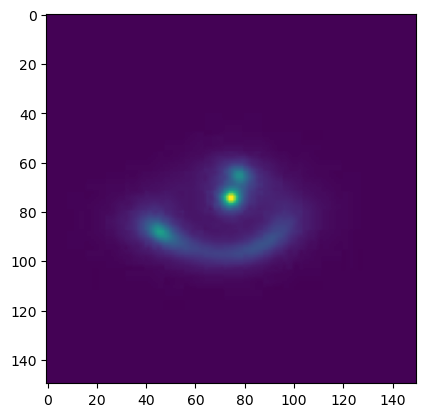

In [3]:
path = '/kaggle/input/lenses/lenses/'
from PIL import Image
img = Image.open('/kaggle/input/lenses/lenses/no_sub/image_100778591073814333588881395008507998957.jpg')
print((np.array(img)).max())
print((np.array(img)/255.0).min())
# plt.imshow(modify(np.array(img)))
plt.imshow(img)

In [4]:
def modify(image):
    image = image.reshape((150,150,1))
    img = tf.reshape(tf.broadcast_to(image, (150, 150, 3)),  (150, 150, 3))
    img = tf.image.resize(np.array(img),[224,224])
    return img

In [5]:
import numpy as np
import keras
import os
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(150,150), n_channels=1,n_classes=10, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            


    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            img = Image.open(path+ '/'.join(ID.split('-')))
            img = modify(np.array(img))
            X[i,] = img/255.0
#             data_augmentation.layers[0].adapt(X)
            label = ID.split('-')
            y[i] = self.labels[label[0]]

        return np.array(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [6]:
import random
trains = []
train_labels = []
l=0
for k in os.listdir(path):
    train = []
    train = [str(k)+'-'+str(i) for i in os.listdir(path+str(k))]
    trains+=(train)
random.shuffle(trains)
train_data = trains[:8000]
val_data = trains[8000:10000]

In [7]:
# val_data
partition = {'train': train_data , 'validation' : val_data}
labels = {}
labels['no_sub'] = 0
labels['sub'] = 1

In [8]:
params = {'dim': (224,224),
          'batch_size': 64,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}


# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

In [9]:
# x, y = training_generator.__getitem__(2)
# plt.imshow(x[39].astype('uint8'))

# ***THERE ARE TWO ARCHITECTURES I HAVE USED FIRST TRANSFER LEARNING FROM PRE TRAINED MODEL AND DISTILLING VISION TRANSFORMER*

# **TRANSFER LEARNING**

In [10]:
!pip install --quiet vit-keras

from vit_keras import vit

In [11]:
vit_model = vit.vit_b32(
        image_size = (224,224),
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

353253686/353253686 [==============================] - 3s 0us/step


In [12]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [13]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = [tf.keras.metrics.AUC()])


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

callbacks = [reduce_lr]

HISTORY = model.fit(training_generator,validation_data = (validation_generator),epochs = 20,callbacks = callbacks, verbose = 1)

Epoch 1/20
125/125 [==============================] - 214s 1s/step - loss: 0.6906 - auc: 0.6422 - val_loss: 0.5594 - val_auc: 0.8636 - lr: 1.0000e-04
Epoch 2/20
125/125 [==============================] - 145s 1s/step - loss: 0.5239 - auc: 0.8995 - val_loss: 0.5475 - val_auc: 0.9429 - lr: 1.0000e-04
Epoch 3/20
125/125 [==============================] - 144s 1s/step - loss: 0.4514 - auc: 0.9611 - val_loss: 0.5343 - val_auc: 0.9581 - lr: 1.0000e-04
Epoch 4/20
125/125 [==============================] - 146s 1s/step - loss: 0.4173 - auc: 0.9786 - val_loss: 0.4476 - val_auc: 0.9797 - lr: 1.0000e-04
Epoch 5/20
125/125 [==============================] - 143s 1s/step - loss: 0.4033 - auc: 0.9845 - val_loss: 0.3818 - val_auc: 0.9948 - lr: 1.0000e-04
Epoch 6/20
125/125 [==============================] - 142s 1s/step - loss: 0.3919 - auc: 0.9884 - val_loss: 0.3856 - val_auc: 0.9952 - lr: 1.0000e-04
Epoch 7/20
125/125 [==============================] - 142s 1s/step - loss: 0.3790 - auc: 0.9917 - va

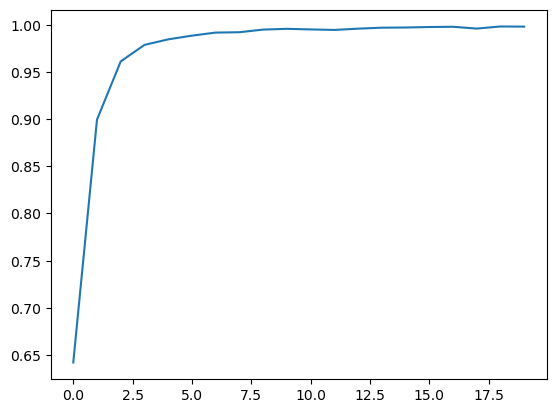

In [14]:
plt.plot(HISTORY.history['auc'])

# **DISTILLING VISION TRANSFORMER**

In [15]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 20
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 2



In [16]:
def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (RESOLUTION + 20, RESOLUTION + 20))
            image = tf.image.random_crop(image, (RESOLUTION, RESOLUTION, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label

    return fn

In [17]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled
            # mode.
            return x, x_dist

class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Forward pass of teacher
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)

        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)


In [18]:
!wget -q https://github.com/sayakpaul/deit-tf/releases/download/v0.1.0/bit_teacher_flowers.zip
!unzip -q bit_teacher_flowers.zip

In [19]:
bit_teacher_flowers = keras.models.load_model("bit_teacher_flowers")

In [20]:
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers)

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=[tf.keras.metrics.AUC()],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
history = deit_distiller.fit(training_generator, validation_data=validation_generator, epochs=20)

Epoch 1/20
125/125 [==============================] - 382s 3s/step - auc_1: 0.4981 - student_loss: 0.8073 - distillation_loss: 0.0132 - val_auc_1: 0.5030 - val_student_loss: 2.6313 - val_distillation_loss: 0.0000e+00
Epoch 2/20
125/125 [==============================] - 356s 3s/step - auc_1: 0.4992 - student_loss: 0.6997 - distillation_loss: 2.3532e-05 - val_auc_1: 0.5025 - val_student_loss: 2.5849 - val_distillation_loss: 0.0000e+00
Epoch 3/20
125/125 [==============================] - 357s 3s/step - auc_1: 0.4992 - student_loss: 0.6972 - distillation_loss: 3.4006e-05 - val_auc_1: 0.5025 - val_student_loss: 2.5018 - val_distillation_loss: 0.0000e+00
Epoch 4/20
125/125 [==============================] - 357s 3s/step - auc_1: 0.4992 - student_loss: 0.7015 - distillation_loss: 4.3236e-05 - val_auc_1: 0.5020 - val_student_loss: 2.4660 - val_distillation_loss: 0.0000e+00
Epoch 5/20
125/125 [==============================] - 360s 3s/step - auc_1: 0.4992 - student_loss: 0.6986 - distillation

In [21]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])

KeyError: 'auc'